In [24]:
import os
import glob
import sys
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage import feature, io
from scipy.stats import norm

sys.path.insert(0, '/Users/tg2684/Downloads/DIMMERs/code/src')  # Adjust the path as needed
from outliers_removal import outliersOut

In [7]:
# Define the location of the file to read
parent_directory = "/Users/tg2684/Downloads/DIMMERs/microscope-data" # modify if needed
experiment = "071620204_pDIMMER_test" # this will be changed for each experiment

# This dictionary defines the folders inside of "experiment" that contain each image type
file_folders = {"image": "MIPs/multi-channel/", 
                "mask_n": "segmentation-masks/nuclei_masks/", 
                "mask_b": "segmentation-masks/background_masks/"}

# This dictionaries will store all image files and their names:
all_images = {"image": [], "mask_n": [], "mask_b": []}
file_names = {"image": [], "mask_n": [], "mask_b": []}


for f in ["image", "mask_n"]:
    # Construct the file path for each of the file types
    access = file_folders[f]
    file_path = os.path.join(parent_directory, experiment, access)

    # List all TIFF files in the directory
    for file_name in glob.glob(os.path.join(file_path, "*.tif")):
        # Read and store the images
        image = tiff.imread(file_name)
        all_images[f].append(image) # Read the image
        file_names[f].append(os.path.basename(file_name)) # Store the file name

# Now, all_images["image"] contains all the images (MIPs), 
# all_images["mask_n"] contains all the nuclei masks and 
# all_images["mask_b"] contains all the background masks

In [8]:
# Print the file names processed -- just run for confirmation
print("Processed files:")
for f in file_names:
    print(f"{f}: {file_names[f]}")

Processed files:
image: ['07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_Pos5_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_50ng_1_MMStack_Pos6_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_250ng_1_MMStack_Pos7_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_250ng_1_MMStack_Pos5_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_250ng_1_MMStack_Pos6_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_250ng_1_MMStack_Pos4_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_Pos4_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_50ng_1_MMStack_Pos7_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_250ng_1_MMStack_Pos4_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_250ng_1_MMStack_Pos6_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_50ng_1_MMStack_Pos5_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_Pos6_MIP.tif', '07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_50ng_1_MMStack_Pos4_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_Pos7_MIP.tif', '07162024_HCT116_NT-EGFP_TLP1c_250ng_1_MMStack_Pos5_MIP.tif

In [9]:
# Check dimensions of a given set of images, to verify they're correct
test_files = [0, 1]
for f in test_files:
    if f < len(all_images['image']):
        print(f"File {f}:")
        print(all_images['image'][f].shape)
        print(all_images['mask_n'][f].shape)
        #print(all_images['mask_b'][f].shape)
    else:
        print(f"File {f} is out of range.")

File 0:
(3, 2048, 2048)
(2048, 2048)
File 1:
(3, 2048, 2048)
(2048, 2048)


In [10]:
# Match image indices to mask indices, to make sure they're paired correctly
# as they may not have been read in the same order

# Assuming file_names['image'] and file_names['mask_n'] contain the file names
image_file_names = file_names['image']
mask_file_names = file_names['mask_n']

# Match each image with its corresponding mask
matched_indices = []
for img_index, img_name in enumerate(image_file_names):
    base_name = os.path.splitext(img_name)[0]
    mask_name = f"C1-{base_name}_cp_masks.tif"
    if mask_name in mask_file_names:
        mask_index = mask_file_names.index(mask_name)
        matched_indices.append((img_index, mask_index))
    else:
        print(f"No matching mask found for image: {img_name}")
        
# Now, matched_indices contains pairs of indices for matched image and mask

In [11]:
print(matched_indices[10])

(10, 8)


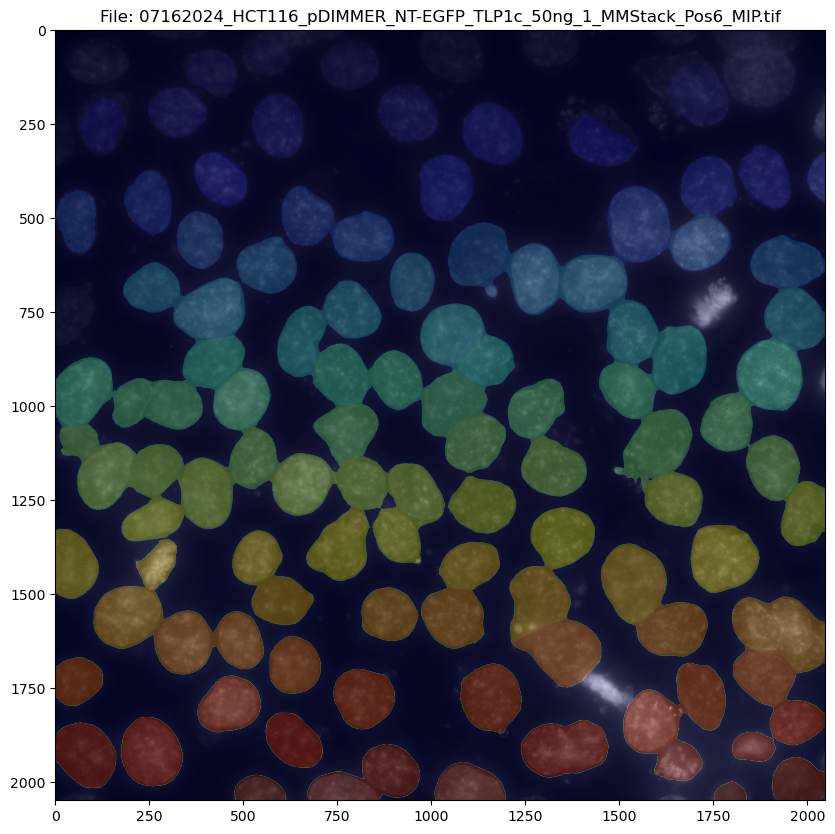

In [12]:
# Overlay the corresponding mask on a channel (given as c) of a given image
# to visually inspect

# Specify the index of the image to check
# and the channel to plot — remember CH1 for ImageJ but channel 0 for Python!
image_index = 1 # Replace with the desired index
c = 0 # remember the channel order in these images

# Find the corresponding mask index
# and define the image and mask pair
mask_index = [pair[1] for pair in matched_indices if pair[0] == image_index][0]

my_image = all_images['image'][image_index]
image_file = file_names['image'][image_index]
my_mask_n = all_images['mask_n'][mask_index]

# Select the c channel
channel_image = my_image[c, ...]

# Overlay the mask on the rest of the image if they have the same dimensions
if channel_image.shape != my_mask_n.shape:
    print("Warning: The image and mask sizes do not match. Please check your data.")
else:
    overlay = np.ma.masked_where(my_mask_n == 0, my_mask_n)
    plt.figure(figsize=(10, 10))
    plt.imshow(channel_image, cmap='gray')  # Display the selected channel in grayscale
    plt.imshow(my_mask_n, cmap='jet', alpha=0.25)  # Overlay the mask with transparency
    plt.title(f'File: {image_file}')
    #plt.axis('off')  # Turn off axis labels
    plt.show()

In [13]:
# Extract a set of metrics for each ROI defined by the mask from the corresponding image

# Create a dictionary to store metrics for each image
all_roi_metrics = {}

# Loop over the matched indices to define the image and mask to utilize
for img_index, mask_index in matched_indices:
    my_image = all_images['image'][img_index]
    my_mask_n = all_images['mask_n'][mask_index]

    # Extract the ID for each of the ROIs — which is their assigned gray level > 0 (0 being the background)
    my_rois = np.unique(my_mask_n)
    my_rois = my_rois[my_rois != 0]

    # Dictionary to store metrics for each ROI in each channel of this image
    roi_metrics = {}

    # Iterate over each ROI
    for roi in my_rois:
        roi_metrics[roi] = {}

        # Calculate area of the ROI
        area = np.sum(my_mask_n == roi)
        
        # Iterate over each channel
        for channel_index in range(my_image.shape[0]):
            # Isolate the ROI in this channel
            roi_pixels = my_image[channel_index, my_mask_n == roi]

            # Check if roi_pixels is empty
            if roi_pixels.size == 0:
                print(f"ROI {roi} in Image {img_index}, Channel {channel_index} is empty.")
                continue
                
            # Calculate metrics
            mean_intensity = np.mean(roi_pixels)
            median_intensity = np.median(roi_pixels)
            std_deviation = np.std(roi_pixels)
            max_value = np.max(roi_pixels)
            min_value = np.min(roi_pixels)
            
            # Store metrics
            roi_metrics[roi][f'Channel {channel_index}'] = {
                'area': area,
                'avg': mean_intensity,
                'median': median_intensity,
                'std': std_deviation,
                'maxima': max_value,
                'minima': min_value
            }

    # Store the metrics for this image
    all_roi_metrics[f'Image {img_index}'] = roi_metrics

# Now, all_roi_metrics contains the metrics for each ROI in each channel for each matched image

In [14]:
# Turn the all_roi_metrics dictionary into a Pandas data frame for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in all_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(data_rows)

In [15]:
# Display the first few rows of the DataFrame to verify it's correct
print(metrics_df.head(10))

   image_index                                           filename  \
0            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
1            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
2            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
3            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
4            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
5            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
6            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
7            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
8            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
9            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   

               experiment  ROI_index  channel   area           avg   median  \
0  071620204_pDIMMER_test          1        0   4903   8255.603712   8116.0   
1  071620204_pDIMMER_test          1        1   4903    538.923312    533.0   
2  

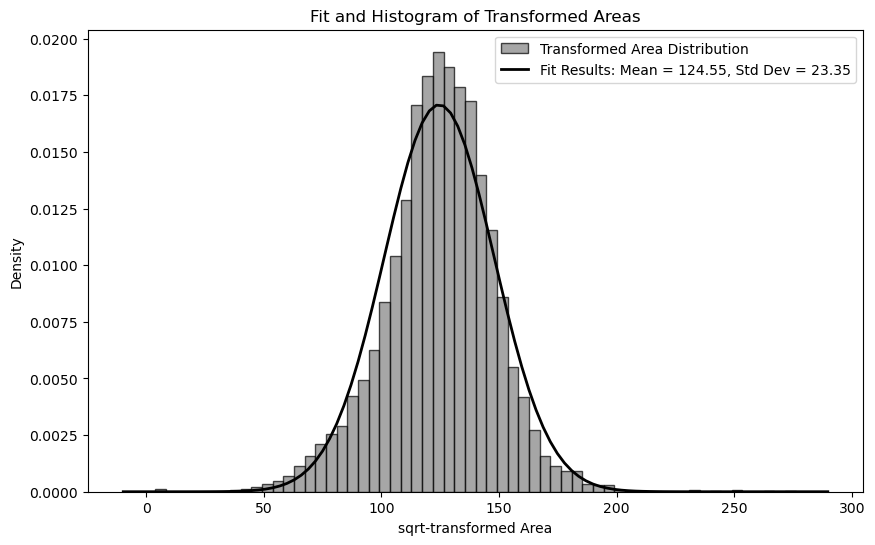

In [16]:
# Plot the distribution of ROI areas in the raw data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_original.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [17]:
# Remove values outside the number of SD that the user defines 
# for the log or sqrt-transformed data, as above
# (2*SD seems generally reasonable for this data)
# using the outliersOut function found in outliers_removal.py
sd_cutoff = 2
tx = "sqrt"

filtr_metrics_df, thresholds = outliersOut(metrics_df, sd_filter = sd_cutoff, transformation = tx)

# Print the thresholds to verify them
print("Calculated thresholds:")
print(f"Mean: {thresholds[0]}, Std Dev: {thresholds[1]}")
print(f"Lower Threshold: {thresholds[2]}, Upper Threshold: {thresholds[3]}")

# Optionally, display some of the filtered data to inspect the results
print(filtr_metrics_df.head())

Calculated thresholds:
Mean: 124.55381865200835, Std Dev: 23.35253797860861
Lower Threshold: 77.84874269479113, Upper Threshold: 171.25889460922556
   image_index                                           filename  \
3            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
4            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
5            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
6            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   
7            0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...   

               experiment  ROI_index  channel   area          avg  median  \
3  071620204_pDIMMER_test          2        0  22576  9141.269888  9197.0   
4  071620204_pDIMMER_test          2        1  22576  1040.375487  1006.0   
5  071620204_pDIMMER_test          2        2  22576   205.740255   205.0   
6  071620204_pDIMMER_test          3        0   7755  6792.985945  6582.0   
7  071620204_pDIMMER_test          3        1   7755

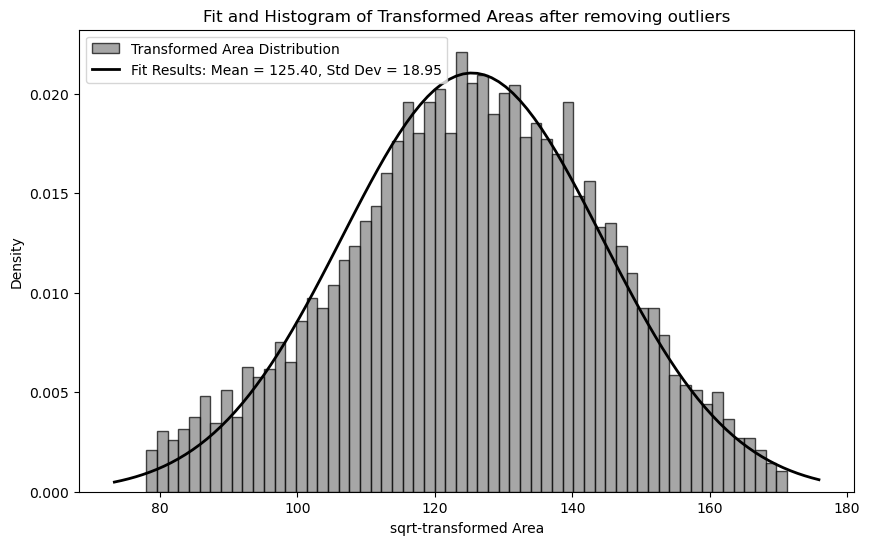

In [18]:
# Plot the distribution of ROI areas in the filtered data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = filtr_metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas after removing outliers')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_no-outliers.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [52]:
# Merge Plasmid Type and Concentration to existing dataframe 

# Define Experimental Groups csv, label "df2"
experimental_groups = '/Users/tg2684/Downloads/DIMMERs/code/reference/experimental-groups.csv'
df2 = pd.read_csv(experimental_groups)

# Join previous data frame with df2
joined_df = pd.merge(filtr_metrics_df, df2, left_on='filename', right_on='filename', how='left')
print(joined_df.head())

                                            filename  image_index  \
0  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...            0   
1  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...            0   
2  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...            0   
3  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...            0   
4  07162024_HCT116_NT-EGFP_TLP1c_50ng_1_MMStack_P...            0   

               experiment  ROI_index  channel   area          avg  median  \
0  071620204_pDIMMER_test          2        0  22576  9141.269888  9197.0   
1  071620204_pDIMMER_test          2        1  22576  1040.375487  1006.0   
2  071620204_pDIMMER_test          2        2  22576   205.740255   205.0   
3  071620204_pDIMMER_test          3        0   7755  6792.985945  6582.0   
4  071620204_pDIMMER_test          3        1   7755   657.110767   656.0   

           std  maxima  minima     tx_area       experiment_folder  \
0  1736.175521   14955    4410  150.253120  07162020

In [53]:
# Print a summary of all_roi_metrics
for image_key, rois in all_roi_metrics.items():
    print(f"{image_key}: {len(rois)} ROIs")
    for roi_key, channels in rois.items():
        print(f"  ROI {roi_key}: {len(channels)} Channels")
        for channel_key, metrics in channels.items():
            print(f"    {channel_key}:")
            for metric, value in metrics.items():
                print(f"      {metric}: {value:.2f}")
        break  # Only print the first ROI for brevity
    break  # Only print the first image for brevity

Image 0: 152 ROIs
  ROI 1: 3 Channels
    Channel 0:
      area: 4903.00
      avg: 8255.60
      median: 8116.00
      std: 1070.03
      maxima: 11986.00
      minima: 5591.00
    Channel 1:
      area: 4903.00
      avg: 538.92
      median: 533.00
      std: 43.83
      maxima: 702.00
      minima: 431.00
    Channel 2:
      area: 4903.00
      avg: 207.48
      median: 207.00
      std: 10.43
      maxima: 295.00
      minima: 170.00


In [54]:
# Replace these with the indices of the image, ROI, and channel you want to inspect
image_index = 5  # First image
roi_index = 9   # ROI with ID 9
channel_index = 0  # First channel

image_file = image_file_names[image_index]
image_key = f"Image {image_index}"
roi_metrics = all_roi_metrics.get(image_key, {})
roi_channel_metrics = roi_metrics.get(roi_index, {}).get(f'Channel {channel_index}', {})

print(f"Metrics for Image {image_index}, ({image_file}), ROI {roi_index}, Channel {channel_index}:")
for metric, value in roi_channel_metrics.items():
    print(f"  {metric}: {value:.2f}")

Metrics for Image 5, (07162024_HCT116_pDIMMER_NT-EGFP_TLP1c_250ng_1_MMStack_Pos4_MIP.tif), ROI 9, Channel 0:
  area: 16179.00
  avg: 9741.87
  median: 8767.00
  std: 2981.47
  maxima: 20636.00
  minima: 5492.00


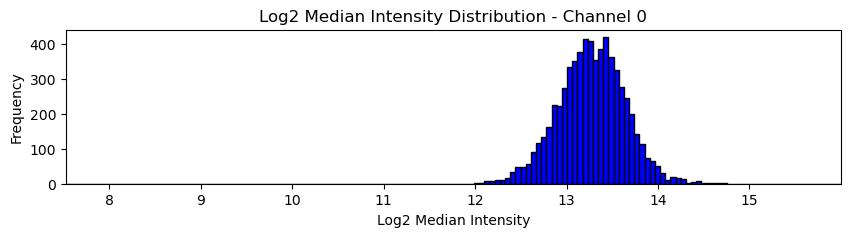

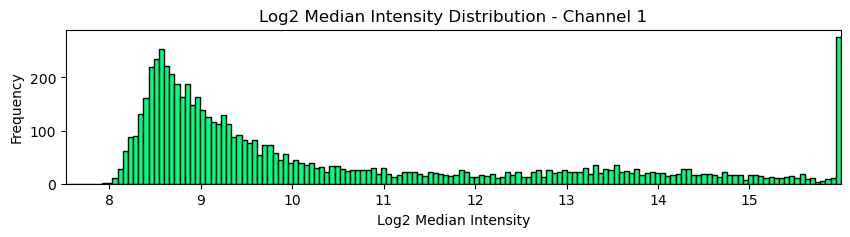

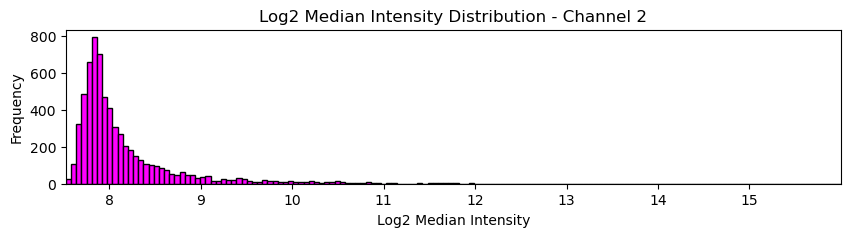

In [55]:
# Plot the data obtained above for average intensity

# Choose the metric to plot:
my_metric = 'median'
x_label = "Median Intensity"

# Transform the metric values to log2
metrics_df['log2_median'] = np.log2(metrics_df[my_metric])

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = metrics_df['log2_median'].min()
global_max_intensity = metrics_df['log2_median'].max()
max_frequency = metrics_df.groupby('channel')[my_metric].count().max()

# Define channel colors
channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}

# Group the data by 'Channel' and then plot histograms for 'Average Intensity'
for channel, data in metrics_df.groupby('channel'):
    # Plot histogram for each channel
    plt.figure(figsize = (10, 2))  # Fix a 5:1 size ratio
    data['log2_median'].hist(bins = 150, 
                               color = channel_colors.get(channel, 'gray'), 
                               edgecolor = 'black', 
                               linewidth = 1, 
                               #density = True, 
                               range = (global_min_intensity, global_max_intensity))
    plt.title(f'Log2 {x_label} Distribution - Channel {channel}')
    plt.xlabel(f'Log2 {x_label}')
    plt.ylabel('Frequency')
    plt.xlim(global_min_intensity, global_max_intensity)
    #plt.ylim(0, max_frequency)
    plt.grid(False)  # Optionally turn off the grid
    plt.show()

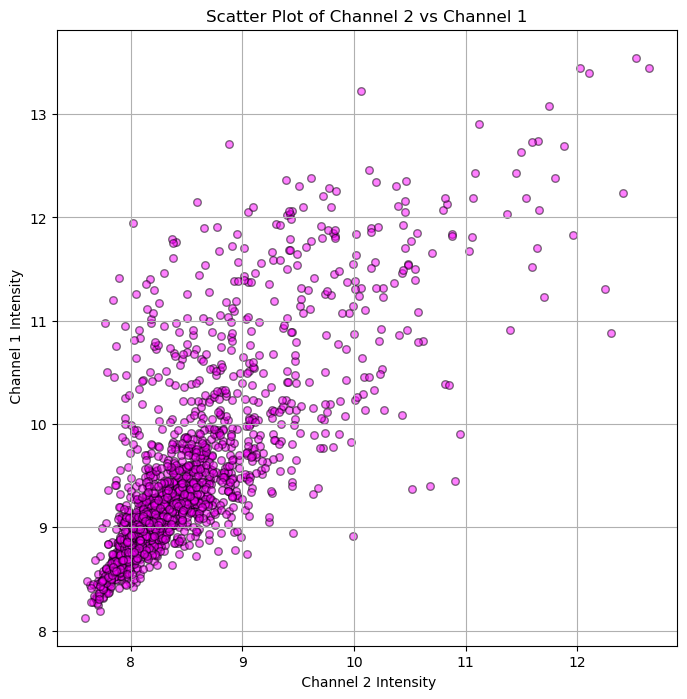

In [67]:
# Now we have to do stuff 

# Apply the initial filter based on FileName and Concentration
filtered_metrics_df = joined_df[(joined_df['filename'].str.contains('pDIMMER_NT-EGFP_TLP1c')) & (joined_df['amount'] == '250ng')]

# Toggle channels for Scatter Plot 
channel_x = 2
channel_y = 1

# Filter data for the chosen channels within the already filtered DataFrame
data_x = filtered_metrics_df[filtered_metrics_df['channel'] == channel_x]
data_y = filtered_metrics_df[filtered_metrics_df['channel'] == channel_y]

# Ensure both dataframes have the same index for merging
data_x = data_x.reset_index(drop=True)
data_y = data_y.reset_index(drop=True)

# Apply log2 transformation to the median values
data_x['log2_median'] = np.log2(data_x['median'])
data_y['log2_median'] = np.log2(data_y['median'])

# Combine the data for scatter plot
combined_df = pd.concat([data_x[['log2_median']].rename(columns={'log2_median': 'x_intensity'}), 
                          data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})], axis=1)

# Plot scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(combined_df['x_intensity'], combined_df['y_intensity'],
            color='magenta', edgecolor='black', alpha=0.5, s=30)
plt.title(f'Scatter Plot of Channel {channel_x} vs Channel {channel_y}')
plt.xlabel(f' Channel {channel_x} Intensity')
plt.ylabel(f' Channel {channel_y} Intensity')
plt.grid(True)
plt.show()